Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    define_Stan_reading_panel_src,
    estimate_model_from_scores,
    format_Stan_data,
    format_Stan_reading_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
    XgboostClassifier,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
score_name = "quality"
# score_name = "linear_score"
m_train_examples: int = 100
m_test_examples: int = 100
noise_scale = 0.87
continue_reading_probability = 0.8

know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:


continue_reading_probability


0.8

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,1,1,1754,0,2,6425,0,3,2780,0,4,2646,0
1,0,4390,0,1,2031,0,2,2692,1,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,1,1,2324,0,2,5815,0,3,1819,0,4,4567,0
4,0,2063,0,1,6283,0,2,3610,0,3,2085,0,4,5610,1


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.45
1,pick_value_1,0.24
2,pick_value_2,0.17
3,pick_value_3,0.09
4,pick_value_4,0.05


In [18]:
# This is the observable data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,1,1754,0,6425,0,2780,0,2646,0
1,4390,0,2031,0,2692,1,4416,0,1913,0
2,599,1,1808,0,64,0,59,0,1671,0
3,1392,1,2324,0,5815,0,1819,0,4567,0
4,2063,0,6283,0,3610,0,2085,0,5610,1
5,2010,1,1465,0,6388,0,25,0,420,0
6,5903,0,1374,0,312,0,926,1,5467,0
7,5194,1,3651,0,1494,0,1749,0,5865,0
8,5946,1,4527,0,5988,0,3021,0,4821,0
9,6469,1,6044,0,2787,0,5786,0,3709,0


In [19]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [20]:
stan_model_reading_panel_src = define_Stan_reading_panel_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_reading_panel_src)
data_reading_str = format_Stan_reading_data(
    observations=observations_train,
    features_frame=features_frame,
)
fit = run_stan_model(
    stan_model_src=stan_model_reading_panel_src,
    data_str=data_reading_str,
)


data {
  int<lower=1> n_vars;                              // number of variables per alternative
  int<lower=1> m_examples;                          // number of examples
  array[m_examples] int<lower=1, upper=5> picked_index;   // which position was picked
  matrix[m_examples, n_vars] x_1;                   // features examples
  matrix[m_examples, n_vars] x_2;                   // features examples
  matrix[m_examples, n_vars] x_3;                   // features examples
  matrix[m_examples, n_vars] x_4;                   // features examples
  matrix[m_examples, n_vars] x_5;                   // features examples
}
parameters {
  vector[n_vars] beta;                              // model parameters
  vector[m_examples] error_picked;                  // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  array[5] vector[m_examples] expected_value;             // modeled expected score of item
  vector[m_examples] v_picked;                      // actual scor

In [21]:
# get implied sample weights from chain
wt_frame = fit.draws_pd(vars=["lp__"])

wt_frame

,lp__
0,-180.677
1,-177.863
2,-171.539
3,-170.392
4,-179.256
...,...
3995,-177.913
3996,-186.002
3997,-174.872
3998,-181.480


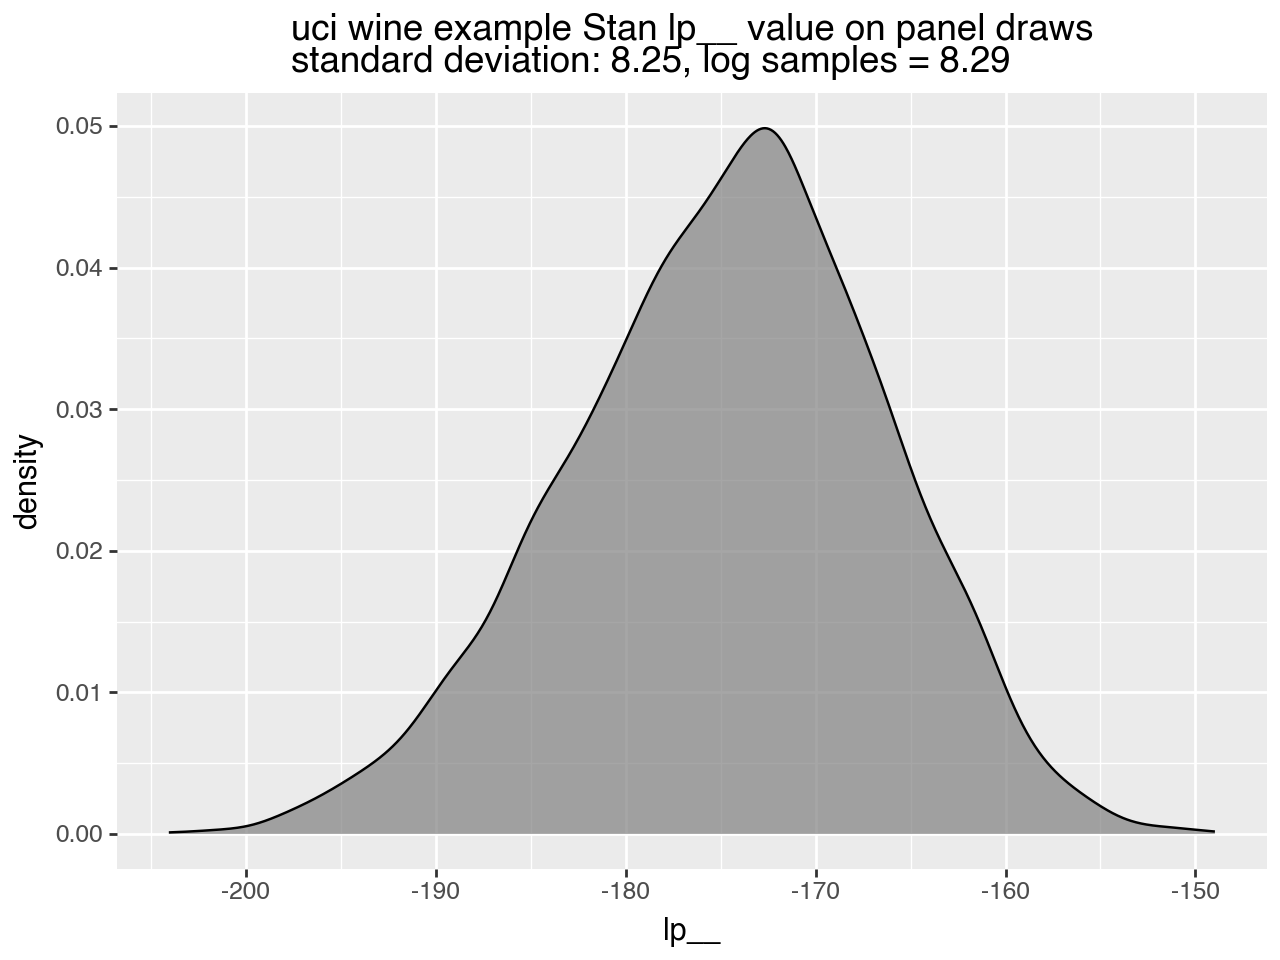

In [22]:
if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on panel draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [23]:
beta_draws = fit.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) 

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,-0.739409,-9.83480,14.629800,-1.984800,-0.901747,0.055563,-0.144162,14.75630,-11.249400,-2.529960,...,-12.427000,0.764047,8.760460,-0.087484,-0.002561,7.71777,1.16838,6.25720,1.04353,2.24329
1,1.338560,-5.31959,4.913840,-0.700624,5.297340,0.058817,-0.153215,-2.08739,-7.728030,0.968292,...,-6.866170,0.471708,0.377476,-0.075463,0.005538,5.01577,-5.18218,9.27521,1.30279,-10.60700
2,1.387340,-4.57632,-0.387912,-1.933480,-10.521700,0.032561,0.012639,6.14639,-6.798840,-1.554500,...,-10.188200,0.529576,-0.149543,-0.063039,0.049661,-16.18630,6.85009,4.32663,2.06471,13.16500
3,1.271520,-3.83277,-0.609198,-2.156930,-11.870500,-0.009493,-0.024567,6.79605,-9.055090,-3.010680,...,-11.345800,0.474102,-1.482620,-0.040799,0.046800,-14.98530,6.53863,4.71277,1.90832,17.03520
4,0.389066,-7.53403,14.573200,-0.047123,5.926990,0.408915,-0.165112,-3.37974,6.621360,-16.853900,...,-3.775730,0.402901,1.815580,-0.038391,0.022946,11.05230,-4.42702,6.06704,1.65802,-14.12900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.124978,2.80686,-0.511606,0.675557,-14.171500,0.168684,-0.112218,-2.28575,-10.590400,-25.294300,...,-5.788160,0.802869,-2.781340,-0.042882,-0.036782,7.79233,-8.07796,13.98970,1.62360,-4.88099
3996,0.614802,1.40581,2.705540,-1.711870,10.285700,0.175881,-0.264269,5.89651,3.107660,11.754600,...,0.672113,0.647916,5.160250,-0.082413,0.020257,-10.40380,1.54476,-4.09059,2.62259,6.91436
3997,-0.324406,-4.28283,0.009919,-0.687941,-17.669100,0.310401,-0.110341,-12.06030,0.619142,-25.247300,...,-8.315240,0.767862,1.179750,-0.036423,-0.042742,16.19700,-7.77694,14.79430,0.97754,-8.05244
3998,0.283137,-1.43404,3.180250,-3.152110,12.496700,0.215506,-0.035062,12.78690,7.843260,7.573710,...,0.771494,0.648180,-2.869430,-0.112356,0.024122,-17.57890,12.10940,2.24623,1.30155,9.84231


In [24]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.5), :
].mean()
# estimated_beta_Stan = beta_draws_display.mean()
estimated_beta_Stan

fixed acidity is red             0.579729
volatile acidity is red         -3.692983
citric acid is red               3.816553
residual sugar is red           -1.472203
chlorides is red                -2.748530
free sulfur dioxide is red       0.165472
total sulfur dioxide is red     -0.145485
density is red                   0.736107
pH is red                        1.265239
sulphates is red                -7.542698
alcohol is red                   1.209860
fixed acidity is white          -1.792302
volatile acidity is white       -7.099799
citric acid is white            -3.458458
residual sugar is white          0.496643
chlorides is white               0.409981
free sulfur dioxide is white    -0.038801
total sulfur dioxide is white    0.004031
density is white                -0.566717
pH is white                      0.529550
sulphates is white               7.116503
alcohol is white                 1.650760
is_red                           0.692823
dtype: float64

In [25]:
estimated_beta_Stan = list(estimated_beta_Stan) + [0] * n_alternatives  # TODO: clean

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2734,False
1,0,1,0.1889,False
2,0,2,0.2102,True
3,0,3,0.1301,False
4,0,4,0.1974,False
5,1,0,0.1197,False
6,1,1,0.2953,True
7,1,2,0.2731,False
8,1,3,0.1291,False
9,1,4,0.1828,False


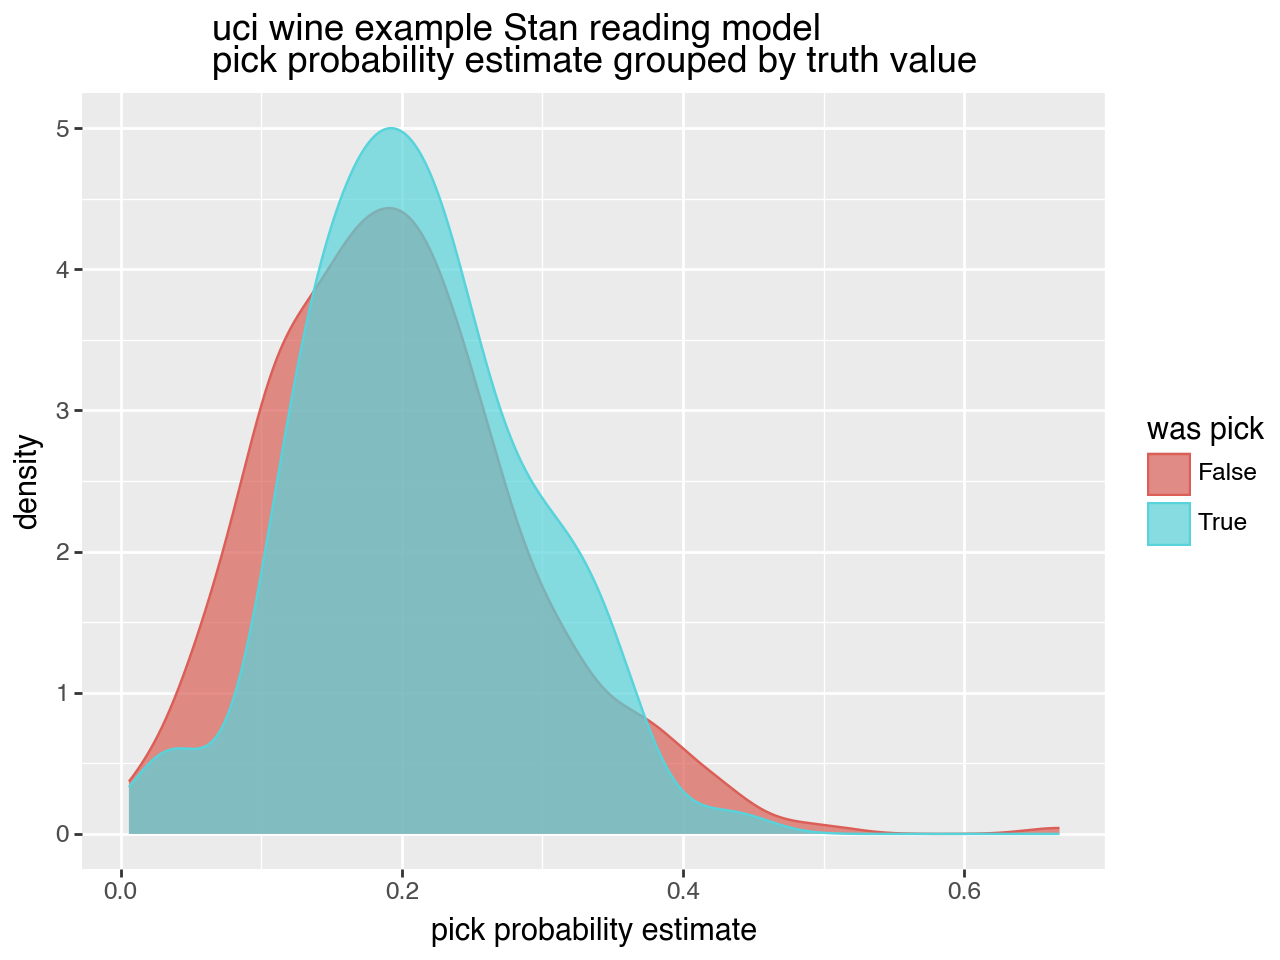

<Figure size 640x480 with 0 Axes>

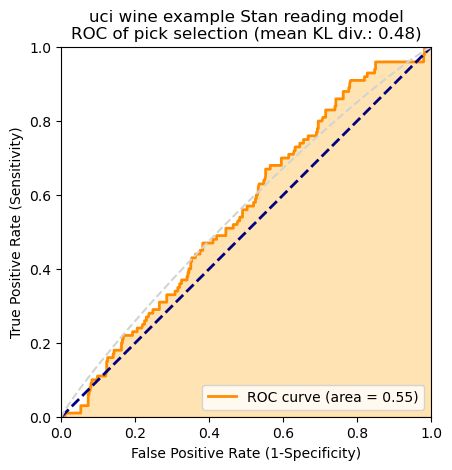

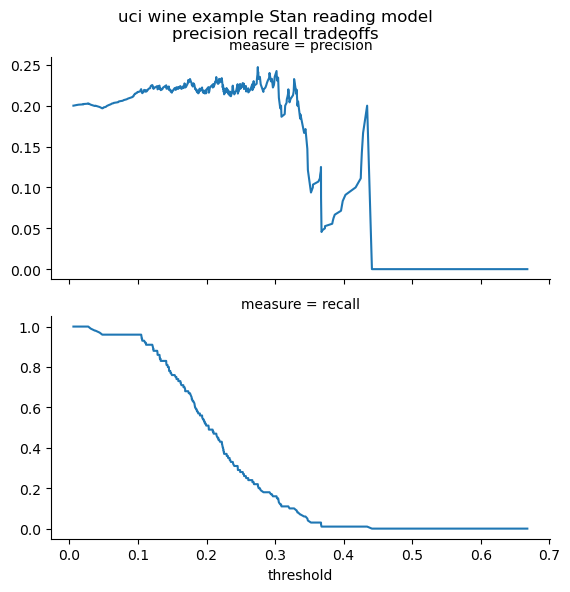

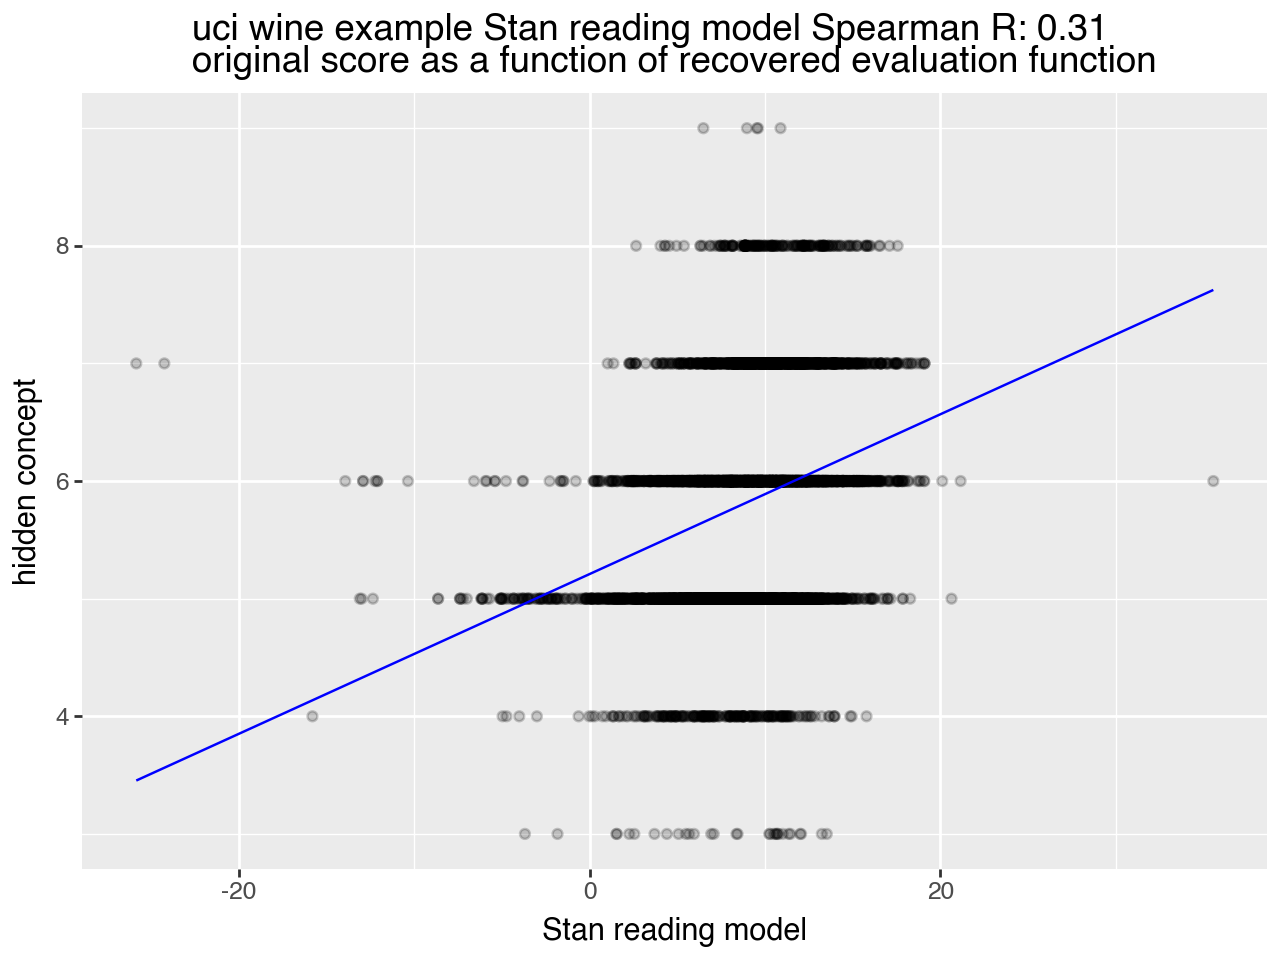

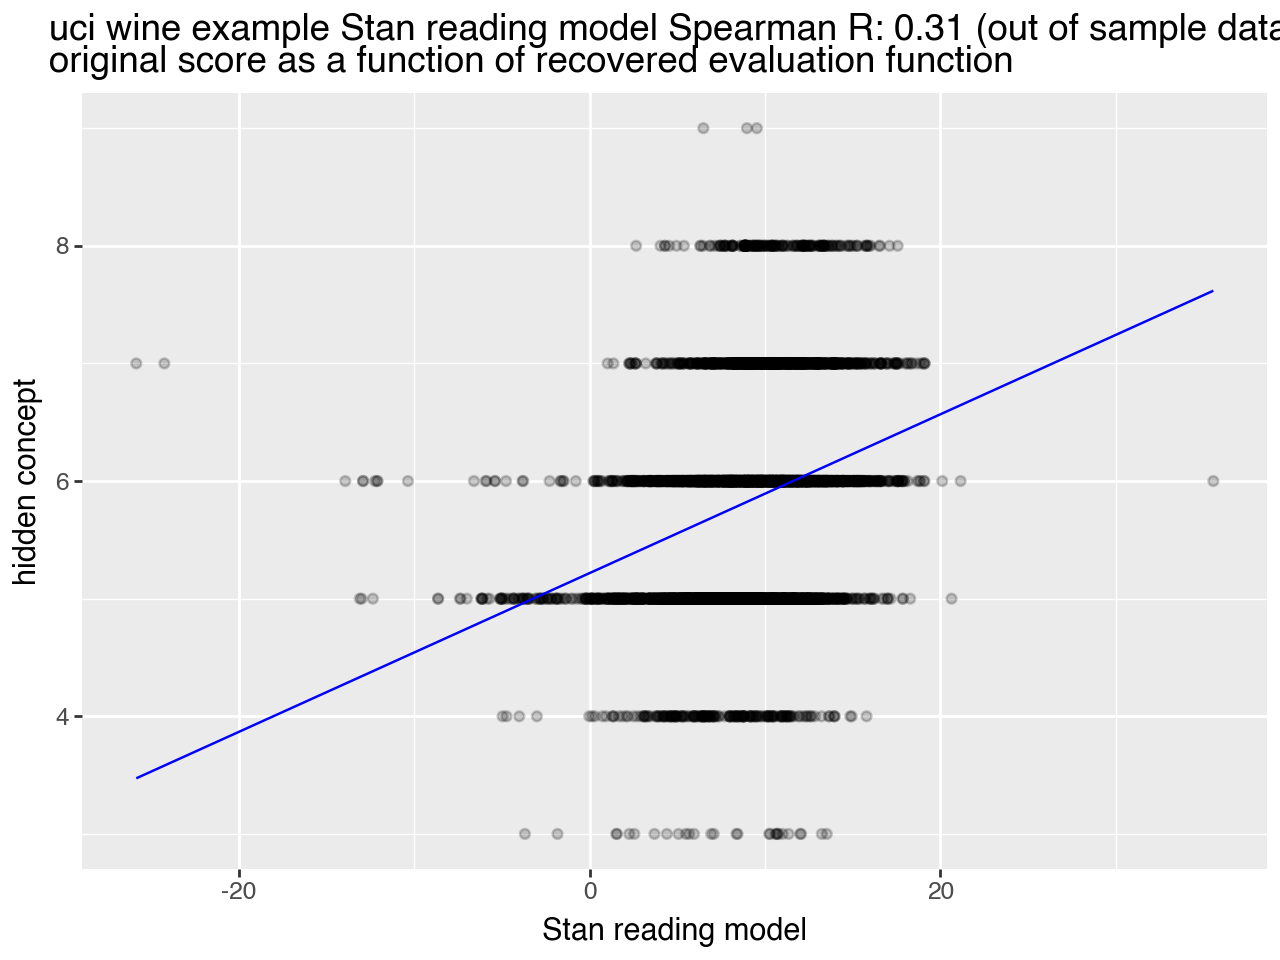

In [26]:
stat_pull = plot_rank_performance(
    model=estimated_beta_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan reading model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

Try to approximate the Stan model with a classification model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [27]:

feature_names = list(features_frame.columns) + [
    f"position_{sel_i}" for sel_i in range(n_alternatives)
]
enc_frame = []
for row_i in range(observations_train.shape[0]):
    feature_row = observations_train.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            posn_vec = [0] * n_alternatives
            posn_vec[sel_pick] = 1.0
            posn_vec[sel_i] = -1.0
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                ) + posn_vec  
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [28]:
classification_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
classification_model_name = 'logistic'

# classification_model = XgboostClassifier(rng=rng)
# classification_model_name = 'xgboost'

# classification_model = RandomForestClassifier()
# classification_model_name = 'Random Forest'

In [29]:

classification_model.fit(
    X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
    y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)

LogisticRegression(max_iter=10000, solver='newton-cholesky')

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2458,False
1,0,1,0.2185,False
2,0,2,0.2078,True
3,0,3,0.1654,False
4,0,4,0.1625,False
5,1,0,0.2282,False
6,1,1,0.2249,True
7,1,2,0.2071,False
8,1,3,0.1798,False
9,1,4,0.1600,False


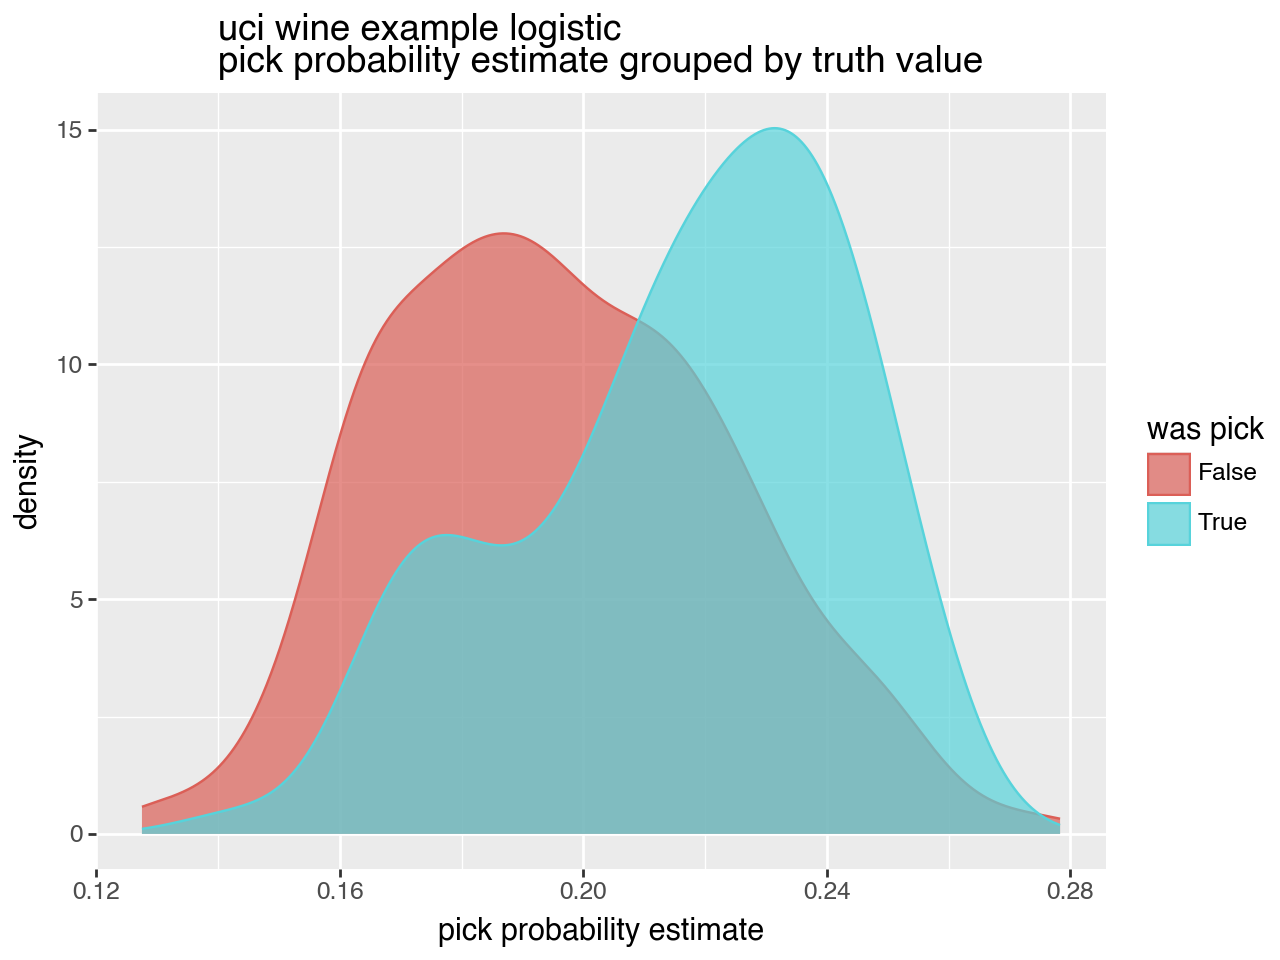

<Figure size 640x480 with 0 Axes>

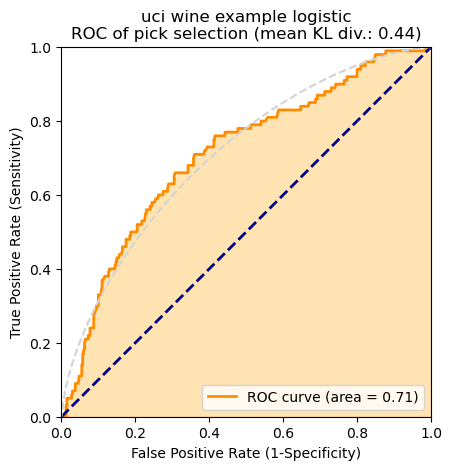

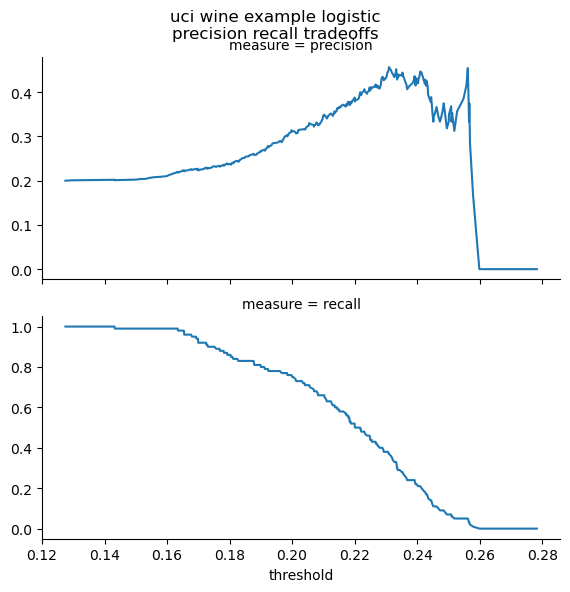

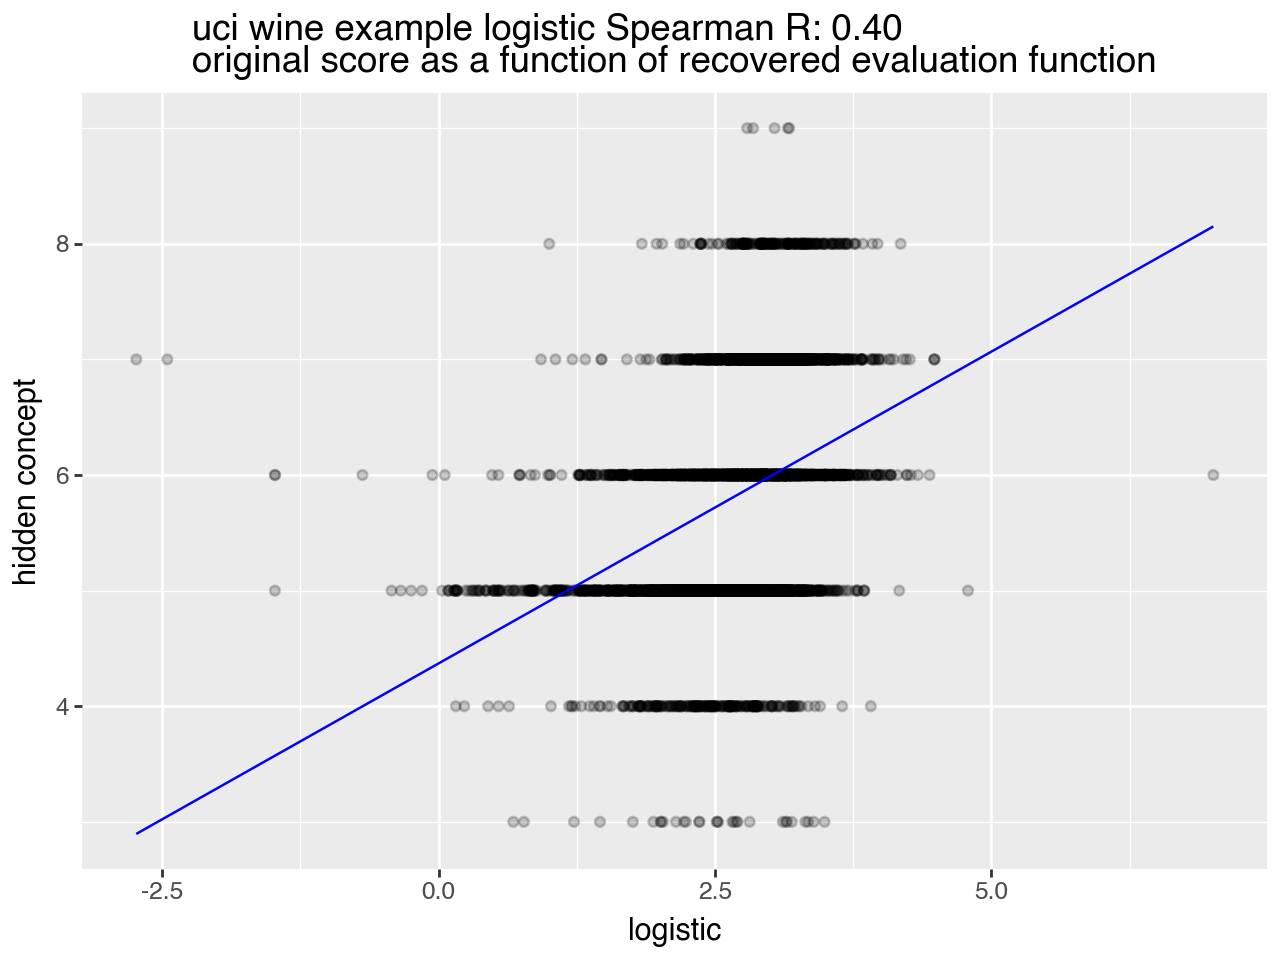

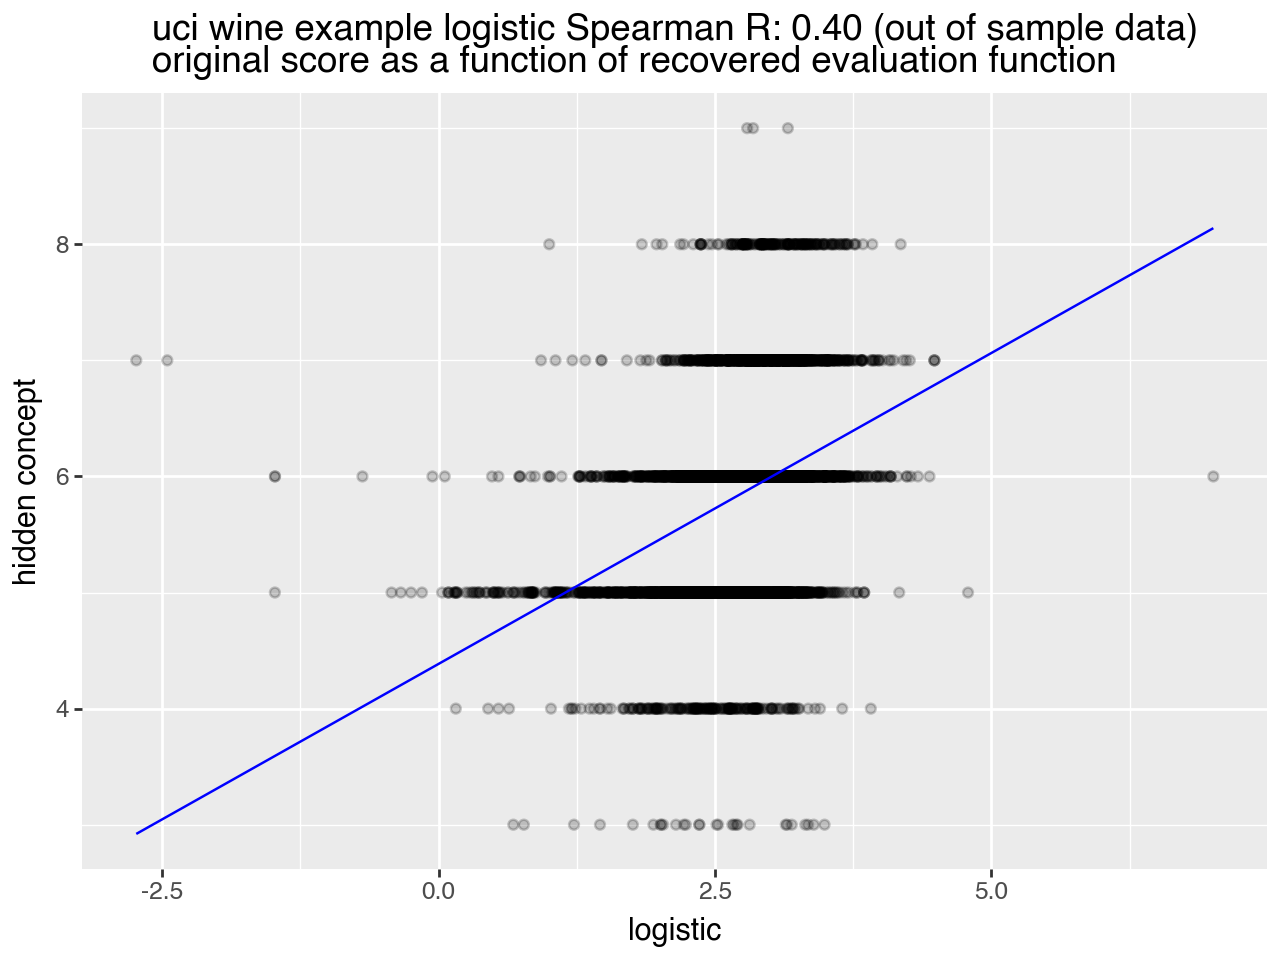

In [30]:
stat_pull = plot_rank_performance(
    model=classification_model,
    model_type='classifier',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name=classification_model_name,  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

We can compare this to just looking at the scores (not implementable in real world problems).

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2131,False
1,0,1,0.1950,False
2,0,2,0.2107,True
3,0,3,0.1986,False
4,0,4,0.1826,False
5,1,0,0.1811,False
6,1,1,0.2125,True
7,1,2,0.2119,False
8,1,3,0.2082,False
9,1,4,0.1863,False


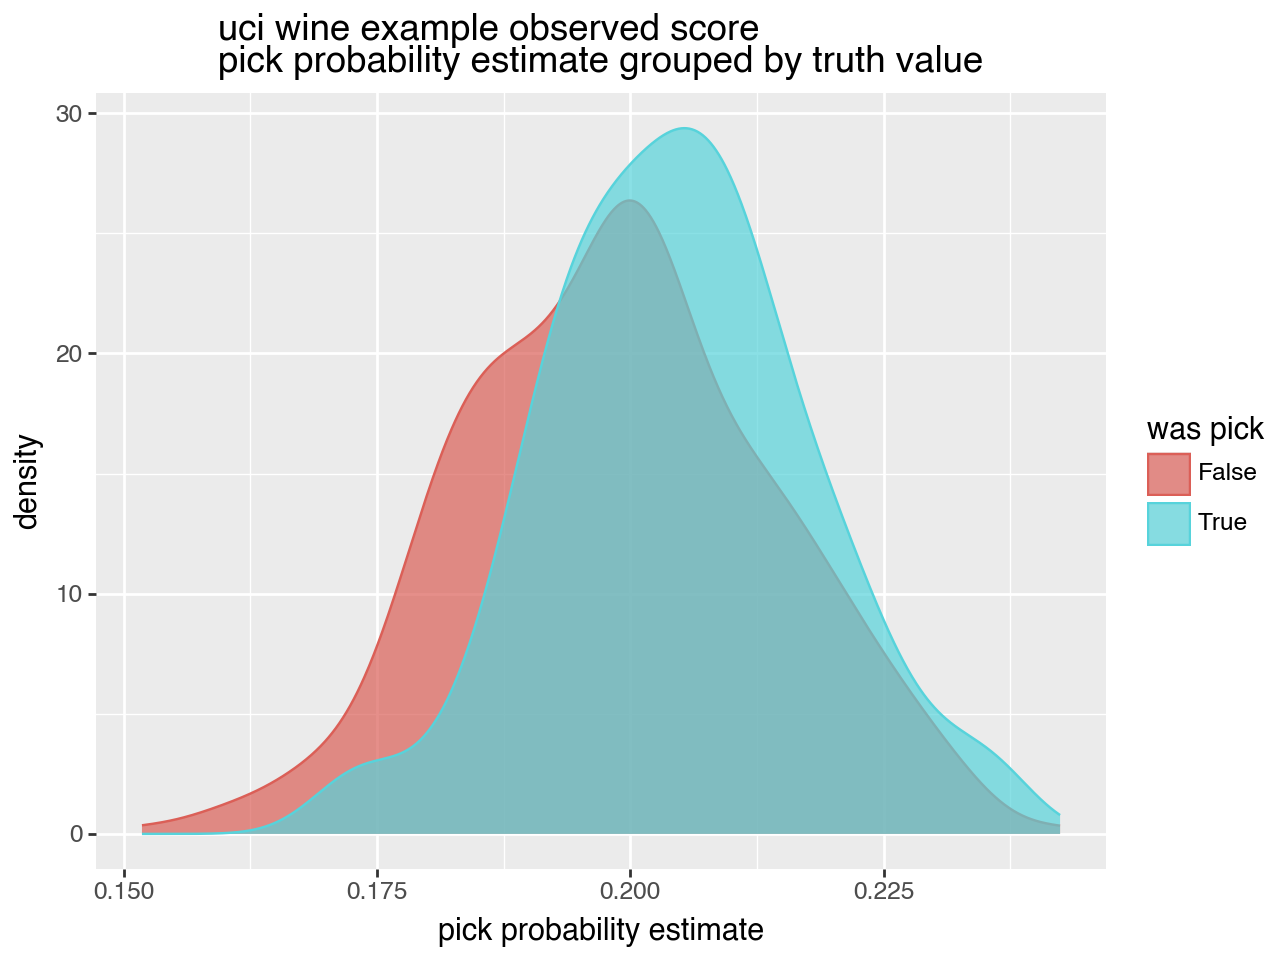

<Figure size 640x480 with 0 Axes>

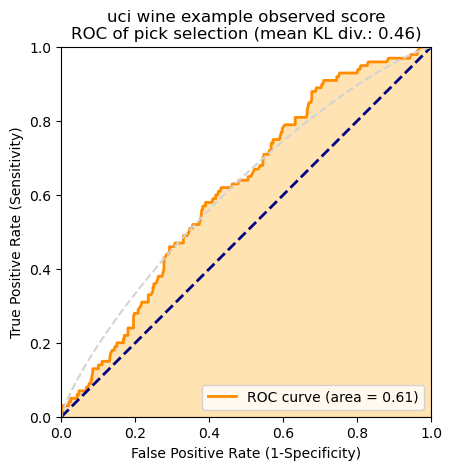

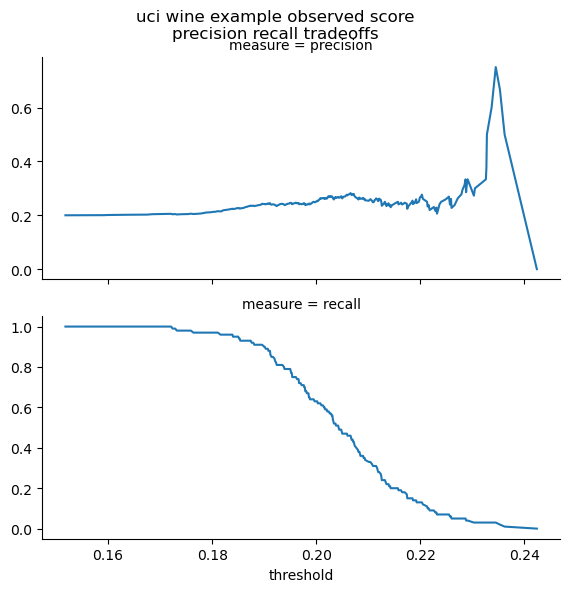

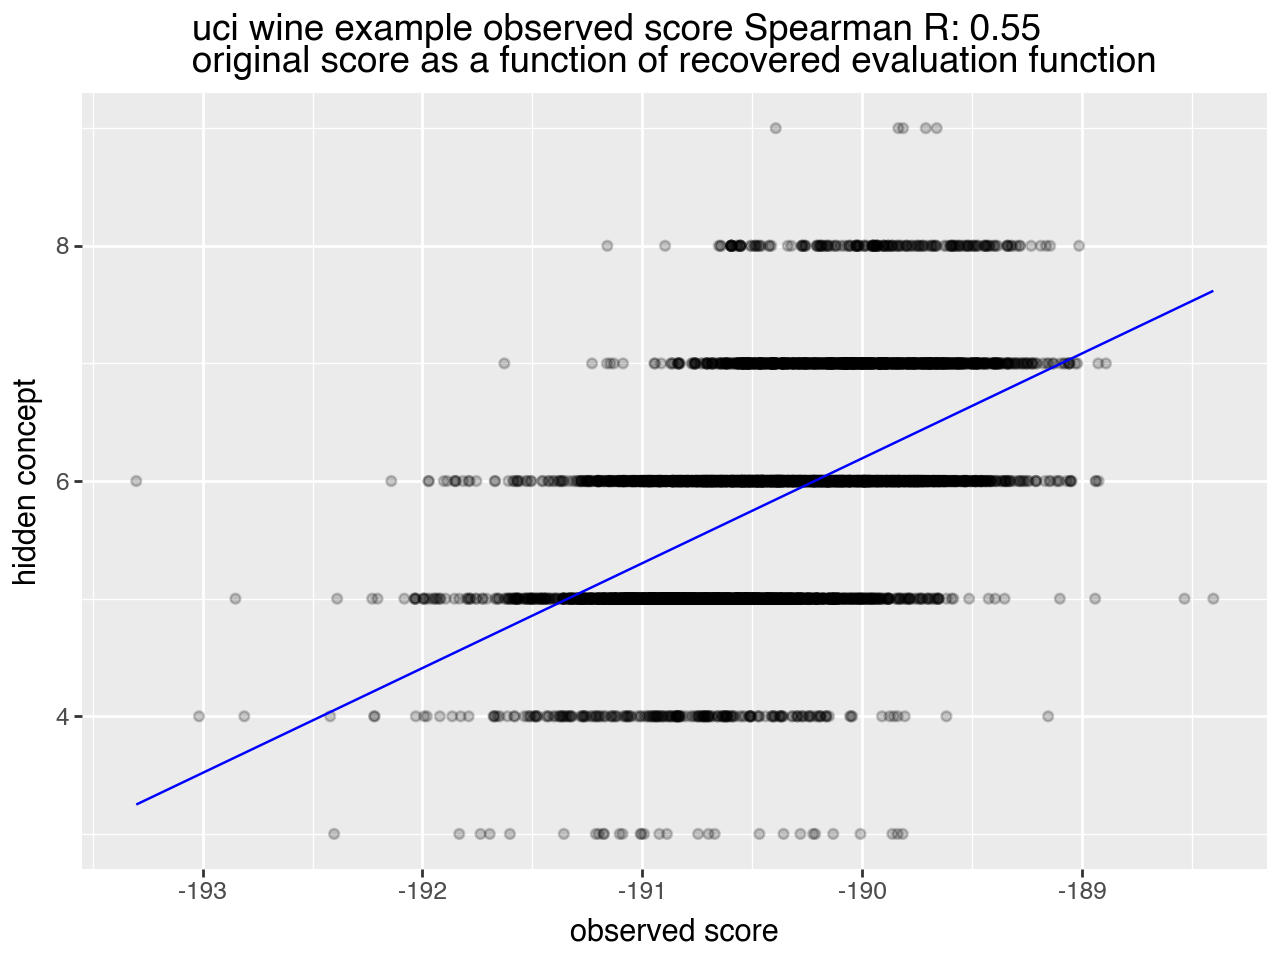

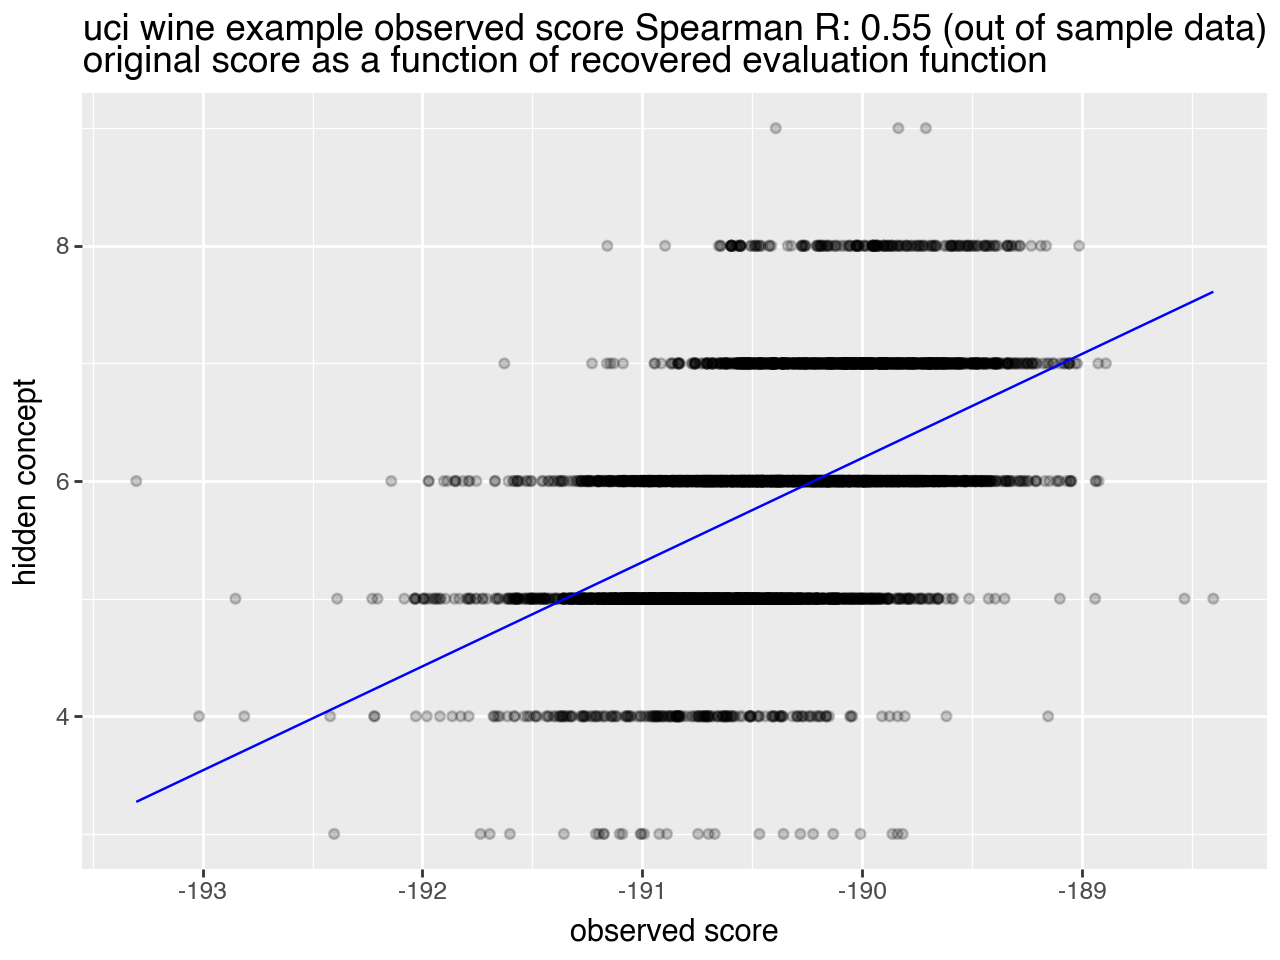

In [31]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef,  # estimated coefficients
        model_type='coef',  # TODO pass regression model directly
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of panels
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [32]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [33]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [34]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training panels,test panels,data_size,test_size
0,uci wine example,Stan reading model,0.311481,0.311068,0.554813,0.477192,100,100,6497,6013
1,uci wine example,logistic,0.401345,0.399807,0.708388,0.443909,100,100,6497,6013
2,uci wine example,observed score,0.551482,0.549029,0.613613,0.458351,100,100,6497,6013
